<a href="https://colab.research.google.com/github/KT2001/Disease_Detection_Technology/blob/master4/DDT_Transfer_learning_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Disease_Detection_Technology

### Introduction

* This Project is to implement Image classification by Cnn to verify if AI could be leveraged in classification of diseases. Implemented the pretrained Model, ResNet50 to train on, radiology scans of diseases such as Covid19, Pneumonia, and Lung Opacity.
* Libraries Used In This Project tensorflow, Matplotlib, numpy, pandas, Keras, PIL, pathlib.
* This Model has achieved 99% Accuracy on Training data, 95% accuracy on Validation data and 95% accuracy on Testing data.
* The Accuracy, F1 Score, Recall and Precision scores are 95.1818611242324 %, 0.9515821860326811, 0.951818611242324 and 0.9525182117751877 respectively.
* This is the First and Basic version Of this Project.

### Research materials used

* M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676 [Paper link](https://ieeexplore.ieee.org/document/9144185)

* Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images. [Paper link](https://www.sciencedirect.com/science/article/pii/S001048252100113X)

* Narayana Darapaneni, Suma Maram, Harpreet Singh, Syed Subhani, Mandeep Kour, Sathish Nagam, Anwesh Reddy Paduri. "Prediction of COVID-19 using chest X-ray images".[Paper link](https://arxiv.org/abs/2204.03849v1)

* This notebook also took inspiiration from the *Covid-19 Radiology | VGG19| f1-score: 95%* by AHMED HAFEZ.[Link to the notebook](https://www.kaggle.com/code/ahmedtronic/covid-19-radiology-vgg19-f1-score-95)

### Dataset

**COVID-19 RADIOGRAPHY DATABASE (Winner of the COVID-19 Dataset Award by Kaggle Community)**

A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Pakistan and Malaysia in collaboration with medical doctors have created a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19, normal, and other lung infection dataset is released in stages. In the first release, we have released 219 COVID-19, 1341 normal, and 1345 viral pneumonia chest X-ray (CXR) images. In the first update, we have increased the COVID-19 class to 1200 CXR images. In the 2nd update, we have increased the database to 3616 COVID-19 positive cases along with 10,192 Normal, 6012 Lung Opacity (Non-COVID lung infection), and 1345 Viral Pneumonia images and corresponding lung masks. We will continue to update this database as soon as we have new x-ray images for COVID-19 pneumonia patients.

The link to the dataset is [here](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database)





In [1]:
!nvidia-smi

Thu Jun 22 15:12:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Importing neccesarry Libraries**

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.utils import class_weight
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Extracting the files**

In [ ]:
!unzip /content/drive/MyDrive/DDT/Dataset/Covid_19_Radiography.zip

In [4]:
# generate data paths
def define_paths(root_folder):
  filepaths = []
  labels = []

  dir = os.listdir(root_folder)

  for files in dir:
    file = os.path.join(root_folder, files)
    # check the folders from main directory. If there are another files, ignore them
    if pathlib.Path(file).suffix != '':
      continue

    filelist = os.listdir(file)
    for paths in filelist:
      fpaths = os.path.join(file, paths)
      # check if there are another folders
      if pathlib.Path(fpaths).suffix == '':
        # check for masks
        if pathlib.Path(fpaths).parts[-1] == 'masks':
          continue
        else:
          final_file = os.listdir(fpaths)
          for f in final_file:
            image_paths = os.path.join(fpaths, f)
            filepaths.append(image_paths)
            labels.append(files)
      else:
        filepaths.append(fpaths)
        labels.append(files)

  return filepaths, labels

In [5]:
filepaths, labels = define_paths('/content/COVID-19_Radiography_Dataset')

In [6]:
# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df=define_df(filepaths, labels)
df.head()

,filepaths,labels
0,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID
1,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID
2,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID
3,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID
4,/content/COVID-19_Radiography_Dataset/COVID/im...,COVID


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  21165 non-null  object
 1   labels     21165 non-null  object
dtypes: object(2)
memory usage: 330.8+ KB


In [9]:
# view distribution of different classes
def show_number_of_classes_bar(df):
  plt.figure(figsize=(25, 25))
  values = df['labels'].value_counts()
  plt.xlabel("number of images available")
  plt.ylabel("Image dataset")
  values.plot(kind = 'barh', color='Red', capsize=10)
  #plt.barh(flowers, values, color = 'Red', capsize = 10)

In [10]:
def show_number_of_classes(df):
  values = df['labels'].value_counts()
  print(f"/n {df['labels']}={values}")

In [11]:
show_number_of_classes(df)

/n 0         COVID
1         COVID
2         COVID
3         COVID
4         COVID
          ...  
21160    Normal
21161    Normal
21162    Normal
21163    Normal
21164    Normal
Name: labels, Length: 21165, dtype: object=Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: labels, dtype: int64


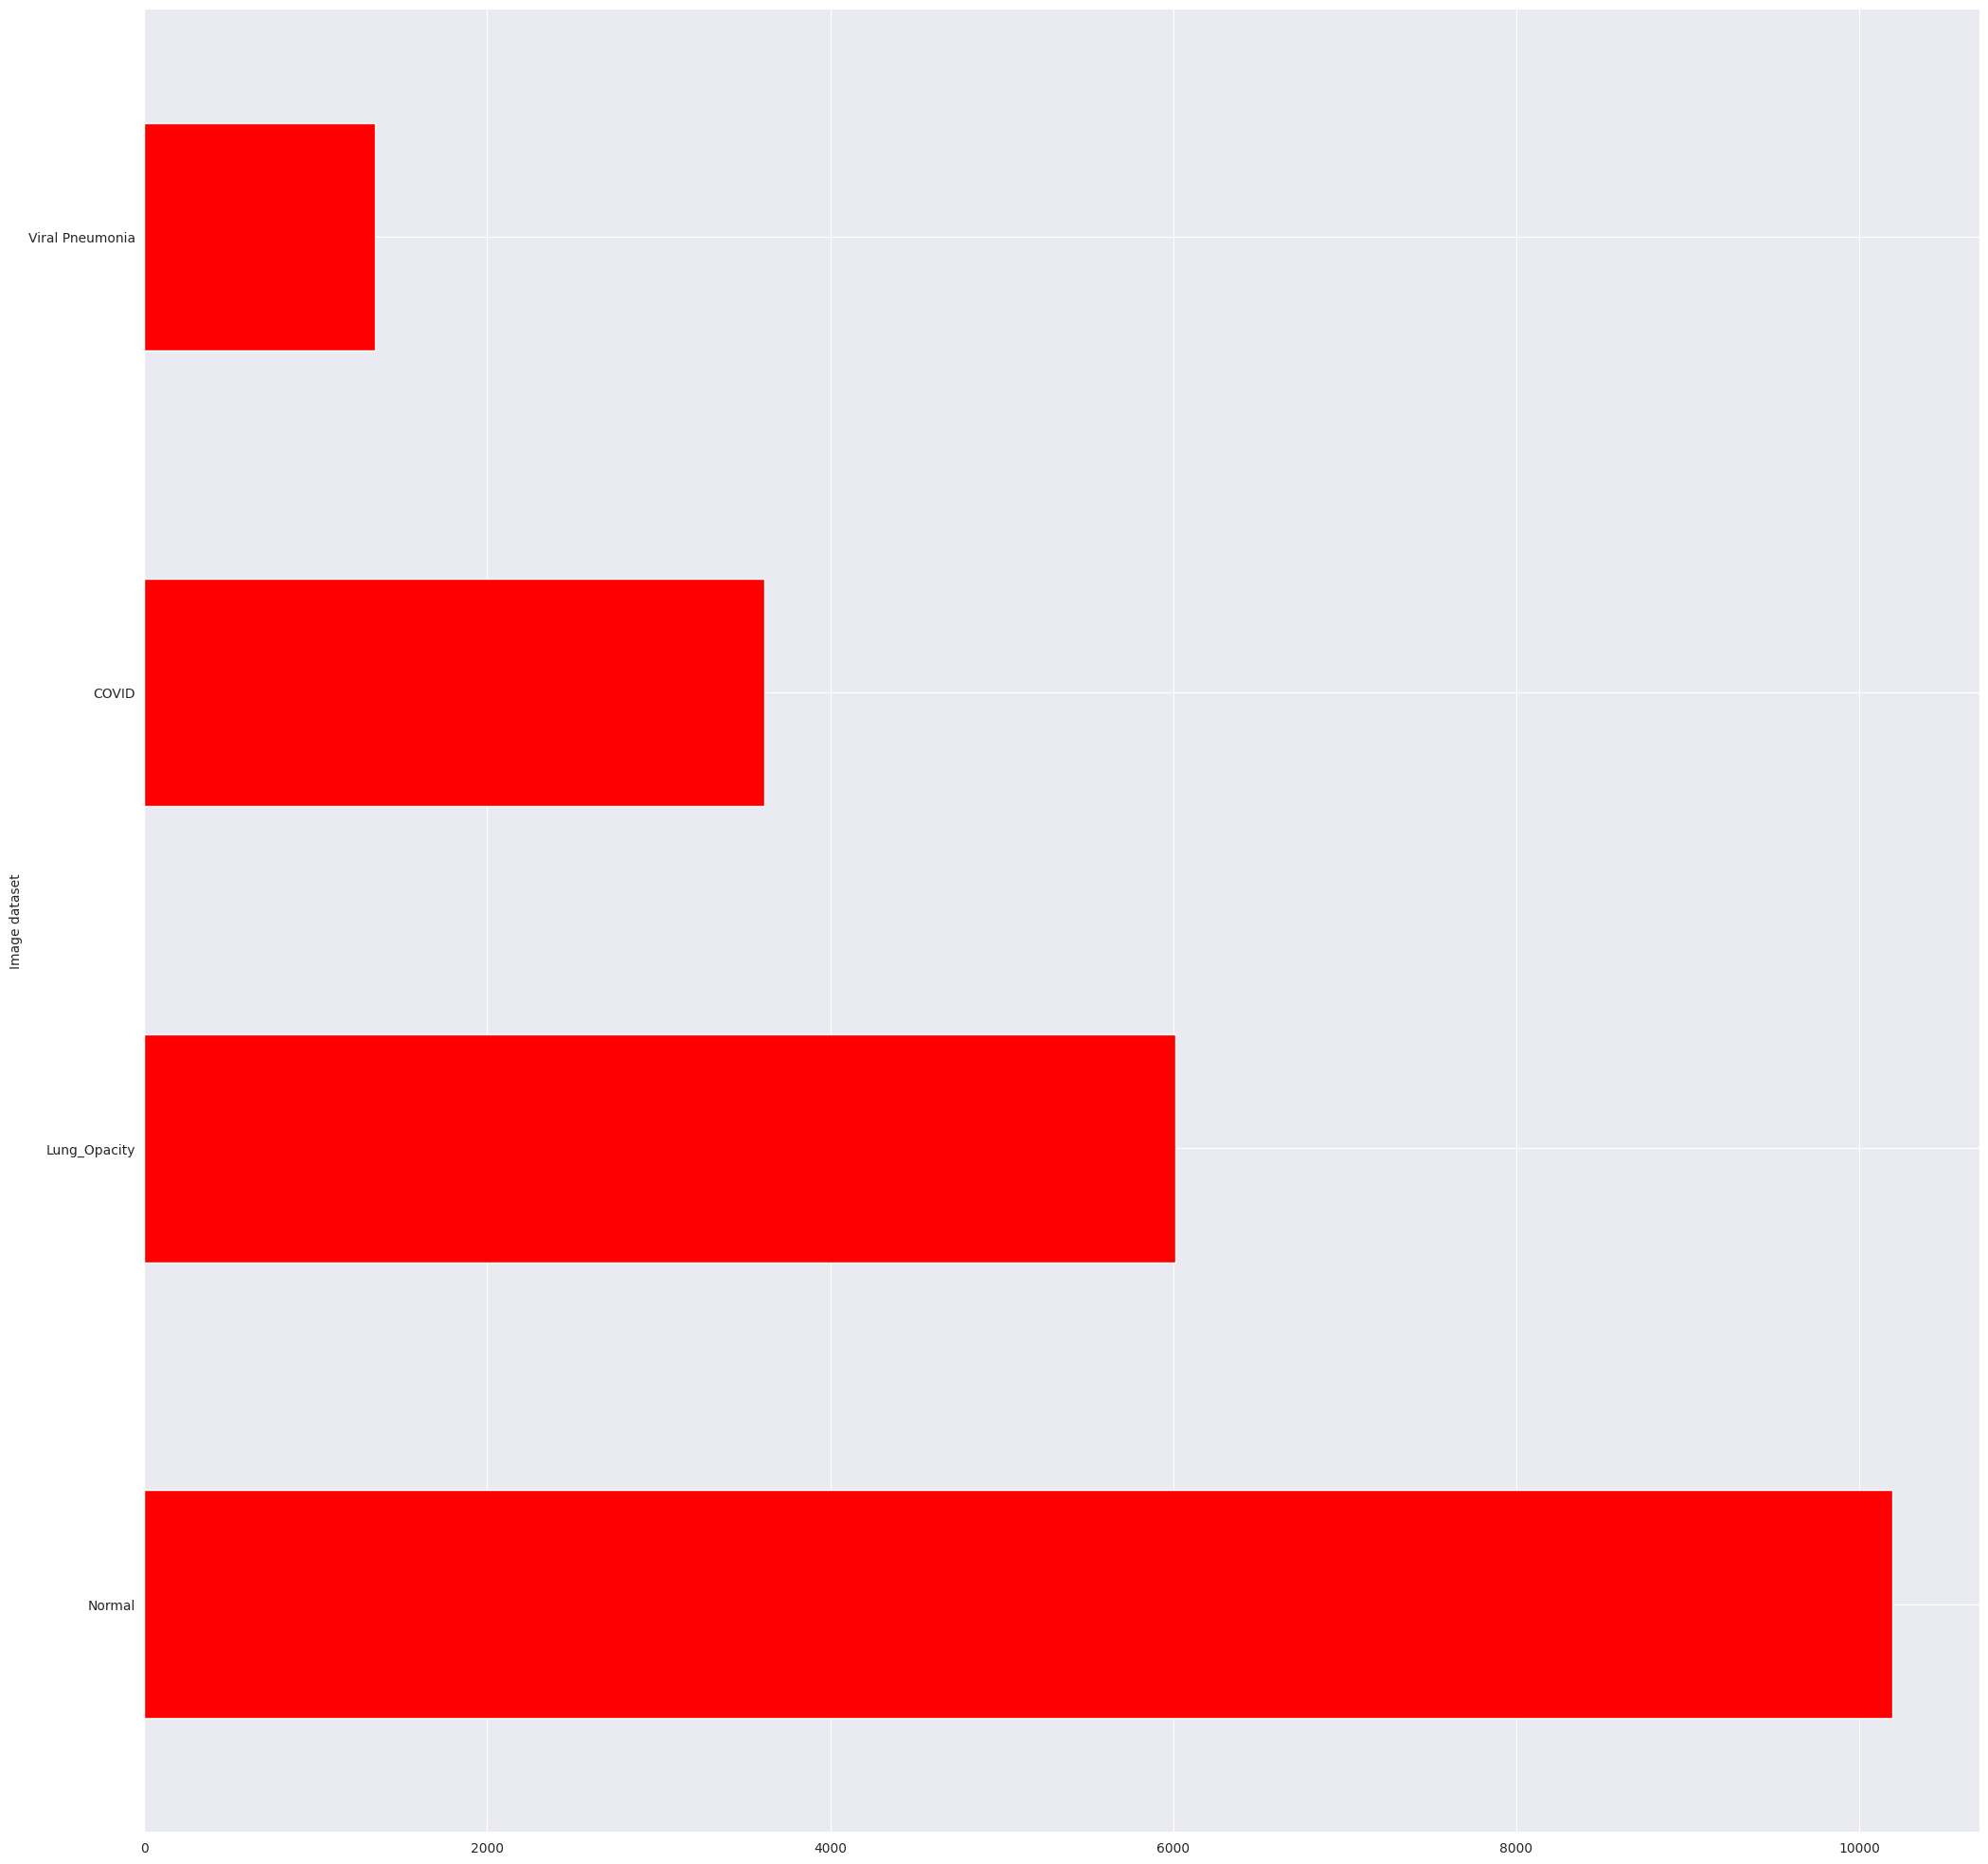

In [12]:
show_number_of_classes_bar(df)

We can see that classes are imbalanced but the gap is extremely big between number of images per class.

# **Preprocessing the images**

In [13]:
# Split dataframe to train, valid, and test
def split_data(df):
  strat = df['labels']
  train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
  # valid and test dataframe
  strat = dummy_df['labels']
  valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)
  return train_df, valid_df, test_df

In [14]:
train_df, valid_df, test_df = split_data(df)

In [15]:
show_number_of_classes(train_df)

/n 1993            COVID
20241          Normal
6594     Lung_Opacity
12428          Normal
5685     Lung_Opacity
             ...     
11578          Normal
19883          Normal
14775          Normal
6862     Lung_Opacity
20735          Normal
Name: labels, Length: 16932, dtype: object=Normal             8154
Lung_Opacity       4809
COVID              2893
Viral Pneumonia    1076
Name: labels, dtype: int64


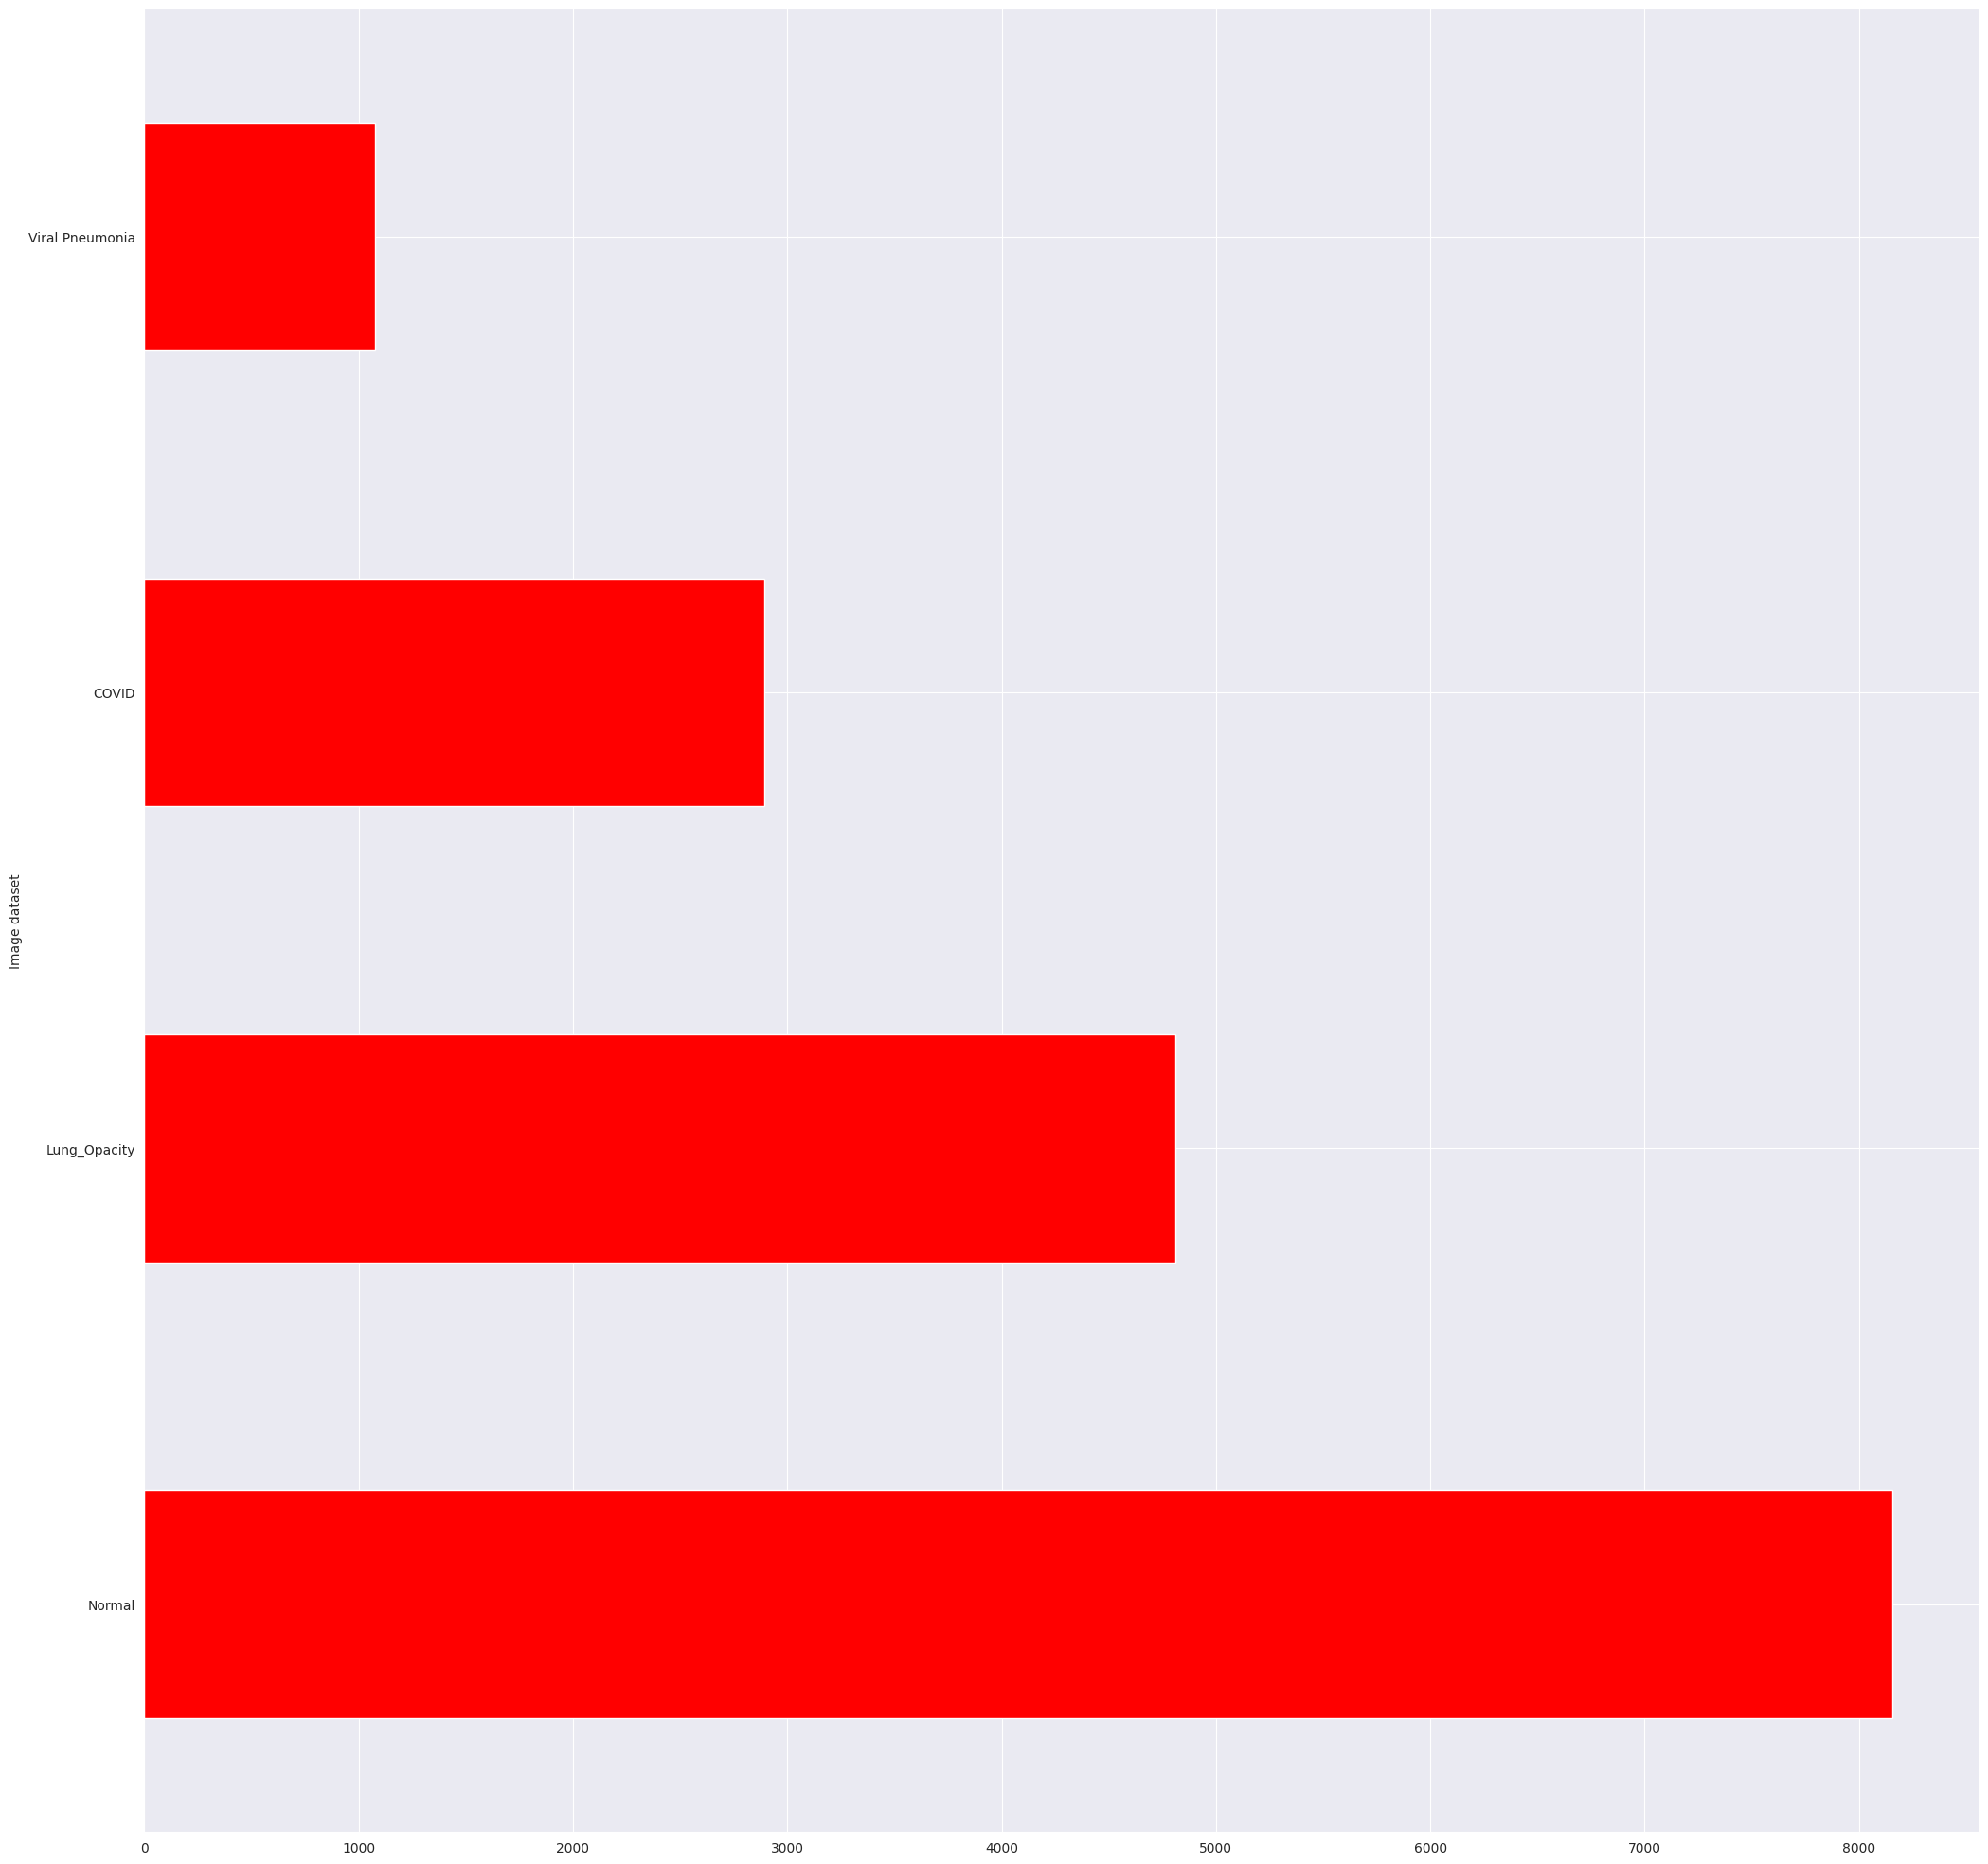

In [16]:
show_number_of_classes_bar(train_df)

In [17]:
def trim(df, max_images, min_images):

  """
  This function will input a df and return a trimmed df with only x amount of max images per class

  """
  trimmed_df = pd.DataFrame(columns = df.columns)#df where we stored our trimmed image paths

  groups=df.groupby('labels')#store images by group


  for label in df['labels'].unique():
        group=groups.get_group(label)#store images in a class

        number_of_images=len(group) #number of images in a class
        #if images > max images then we randomly pick 'max images'
        if number_of_images > max_images:
            s=group.sample(n=max_images, random_state=42,axis=0) #we pick x amount of random samples
            trimmed_df=pd.concat([trimmed_df, s], axis=0)#add to df
        else:
            #Now if number of images is > min images but < max images, we simply add it to the df and fill later with augmented images
            if number_of_images >=min_images:
                s=group
                trimmed_df=pd.concat([trimmed_df, s], axis=0)#add to df


  print(f'The max images are:{max_images} and the minimum images are: {min_images}')
  return trimmed_df

In [18]:
max_images=1076 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_images=1000
column='labels'
trimmed_df = trim(train_df, max_images, min_images)

The max images are:1076 and the minimum images are: 1000


In [19]:
show_number_of_classes(trimmed_df)

/n 382               COVID
829               COVID
1791              COVID
722               COVID
556               COVID
             ...       
4815    Viral Pneumonia
3889    Viral Pneumonia
4091    Viral Pneumonia
3847    Viral Pneumonia
4743    Viral Pneumonia
Name: labels, Length: 4304, dtype: object=COVID              1076
Normal             1076
Lung_Opacity       1076
Viral Pneumonia    1076
Name: labels, dtype: int64


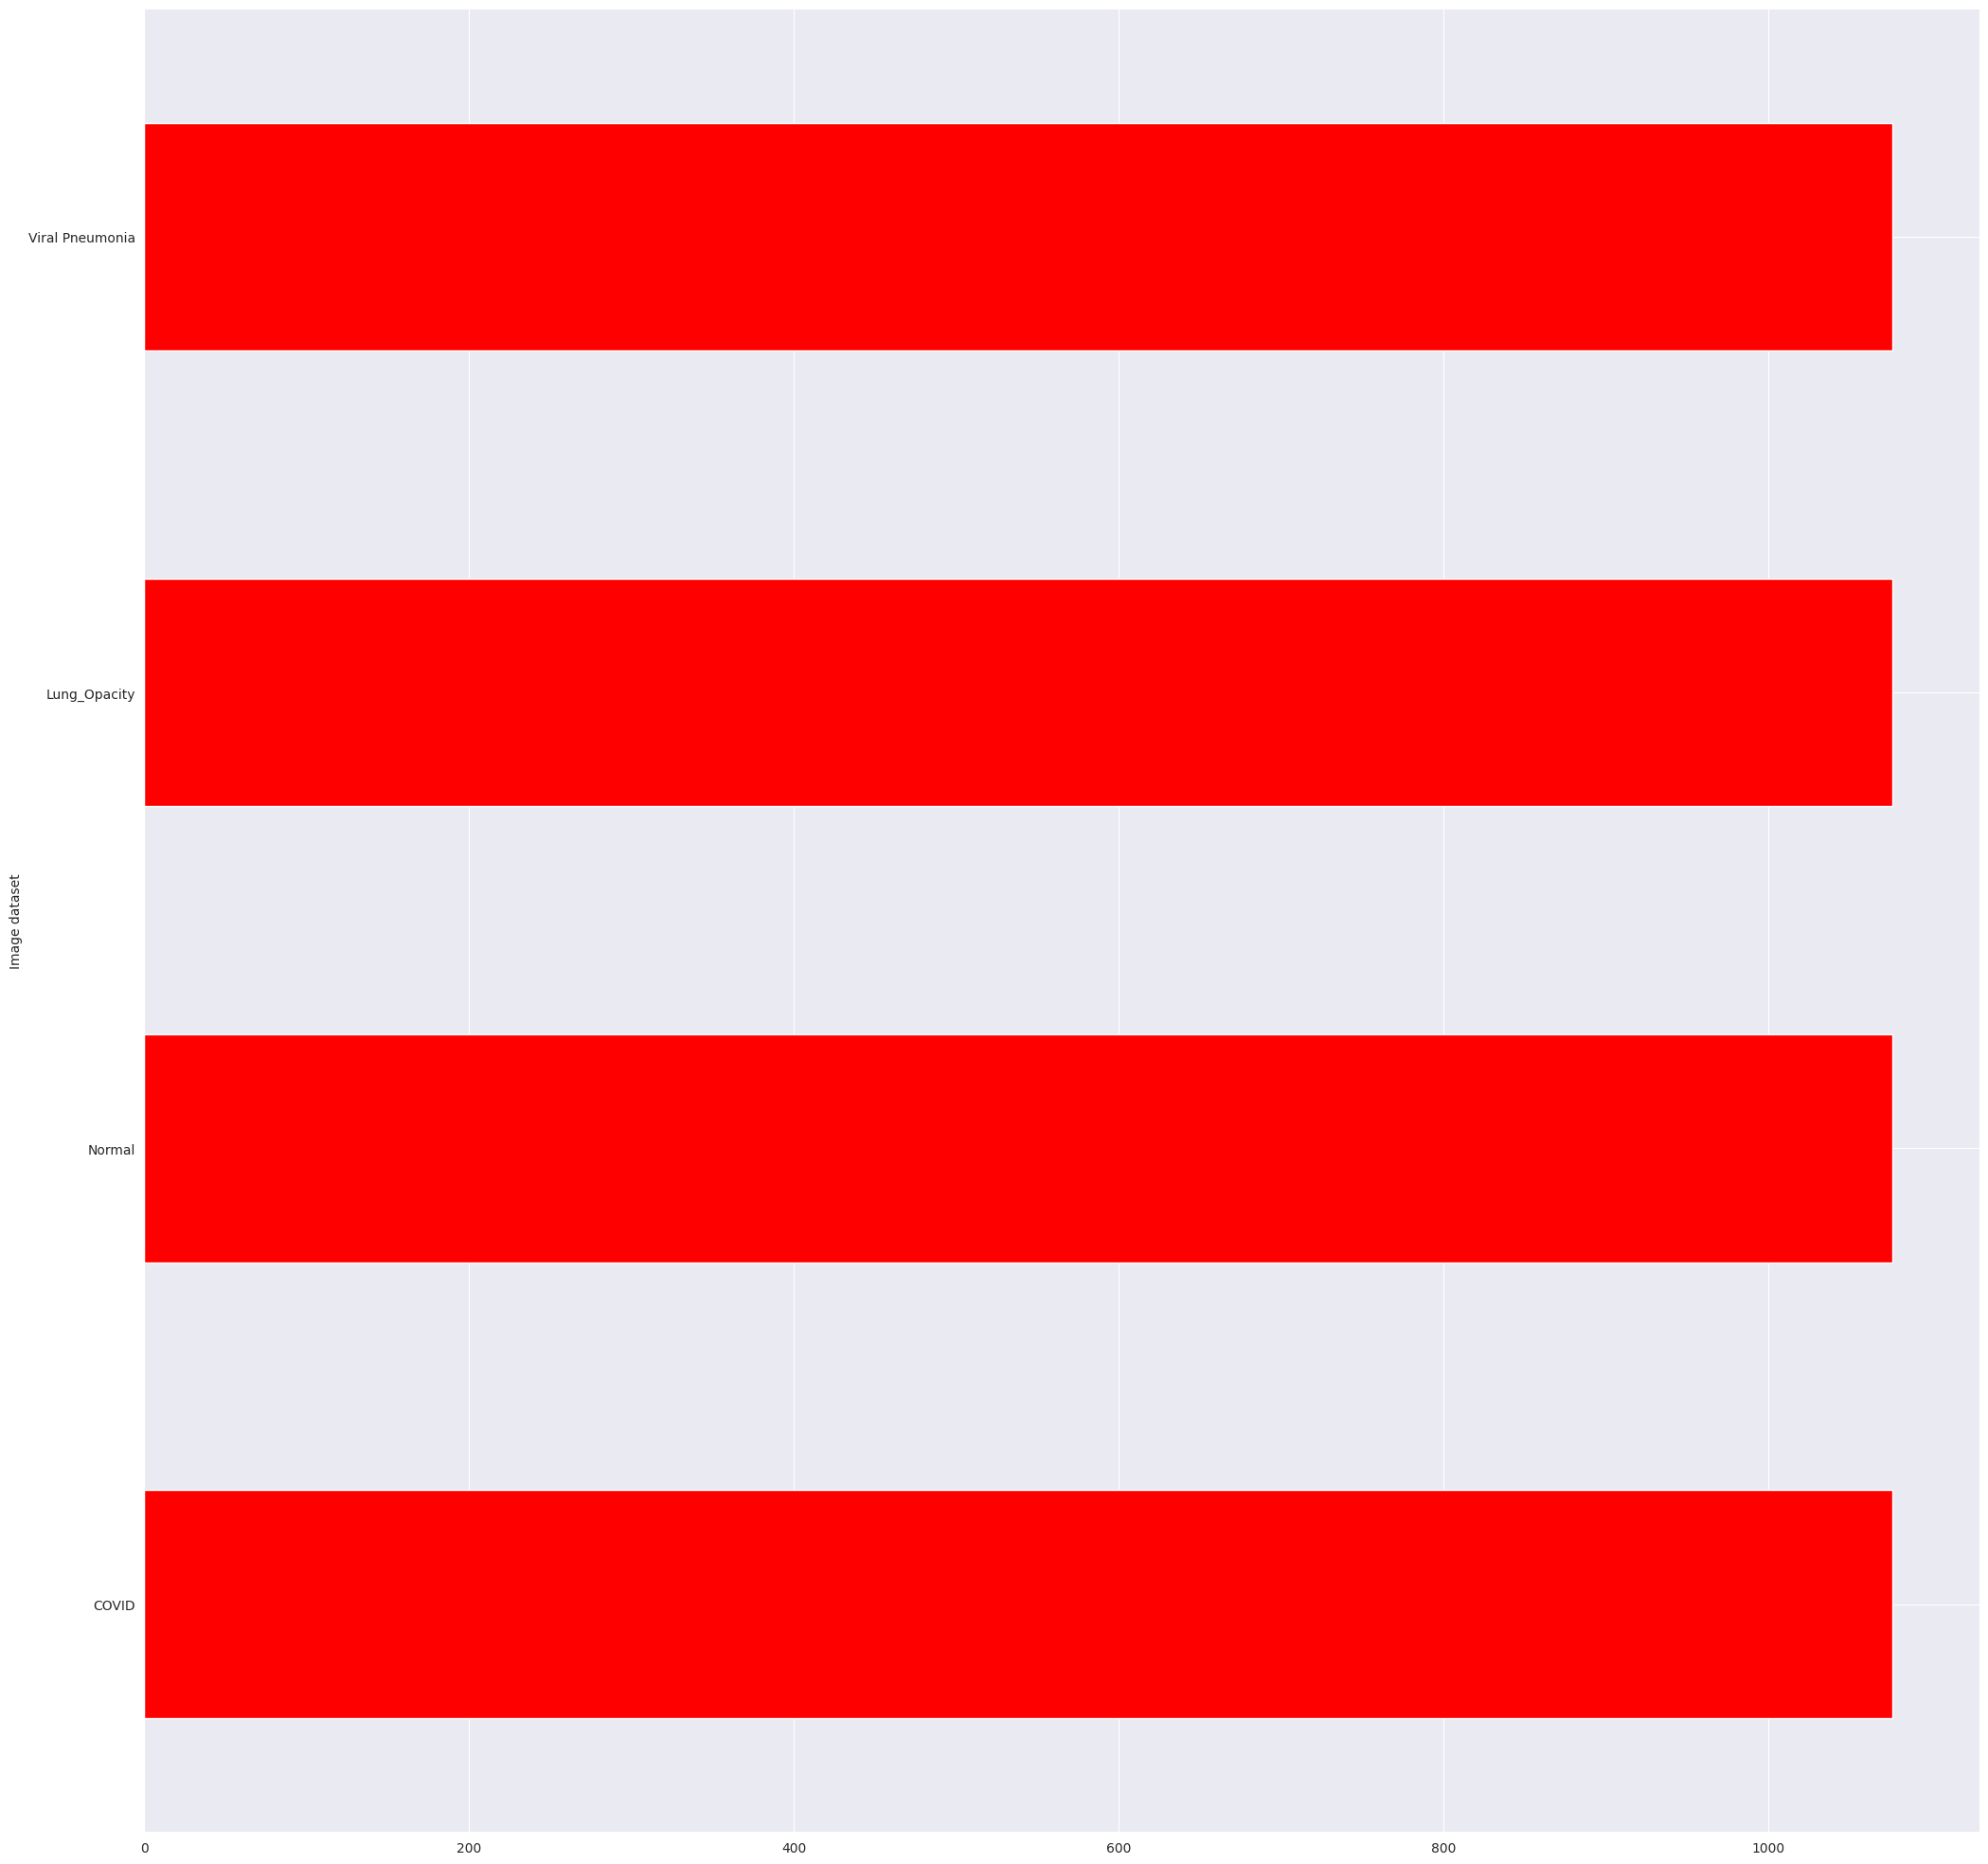

In [20]:
show_number_of_classes_bar(trimmed_df)

# Augmentation


In [23]:
# optional
def Augment(df, n, working_dir, img_size):
    print('Initial length of dataframe is ', len(df))

    augment_dir = os.path.join(working_dir, 'AUG')  # directory to store augmented images
    os.mkdir(augment_dir)

    for label in df['labels'].unique():
        dir_path = os.path.join(augment_dir, label)
        os.mkdir(dir_path)  # make class directories within aug directory

    # Counter variable for total augmented images
    total = 0
    rotation_translation_gen = ImageDataGenerator(rotation_range=10, width_shift_range=.1,
                                                 height_shift_range=.1)

    translation_gen = ImageDataGenerator(width_shift_range=.1,
                                         height_shift_range=.1)

    # Define a dictionary mapping class labels to their corresponding augmentations
    class_augmentations = {
        'COVID': rotation_translation_gen,
        'Lung_Opacity': rotation_translation_gen,
        'Normal': translation_gen,
        'Viral Pneumonia': translation_gen
        # Add more classes and their augmentations as needed
    }

    groups = df.groupby('labels')  # store images grouped by class

    for label, datagen in class_augmentations.items():
        group = groups.get_group(label)  # store image paths for a particular label
        number_of_images = len(group)  # determine how many samples there are in this class

        if number_of_images < n:  # if the class has less than target number of images
            aug_img_count = 0  # counter variable for number of aug images created for that class
            difference = n - number_of_images  # number of augmented images to create

            if difference > 300:
                difference = 300  # Limit the number of augmented images to add to 500

            target_dir = os.path.join(augment_dir, label)  # define where to write the images
            print(f'For {label} creating {difference} augmented images. ', end='')
            aug_gen = datagen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                                  class_mode=None, batch_size=1, shuffle=False,
                                                  save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                                  save_format='png')

            while aug_img_count < difference:
                # Generate augmented images and save them
                batch_images = next(aug_gen)
                aug_img_count += 1
                total += 1
                print(f'{aug_img_count}/{difference}', end=' ')
            print('\n')

    print('Total augmented images created: ', total)

In [ ]:
'''
# optional code cell, as it has been noticed, that the score is still above 90%
def Augment(df, n, working_dir, img_size):
  print('Initial length of dataframe is ', len(df))


  augment_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
  os.mkdir(augment_dir)


  for label in df['labels'].unique():
      dir_path=os.path.join(augment_dir,label)
      os.mkdir(dir_path) # make class directories within aug directory


  #counter variable for total augmented images
  total=0
  rotation_translation_gen=ImageDataGenerator(rotation_range=10, width_shift_range=.1,
                                height_shift_range=.1)

  translation_gen=ImageDataGenerator(width_shift_range=.1,
                                height_shift_range=.1)

  # Define a dictionary mapping class labels to their corresponding augmentations
  class_augmentations = {
    'COVID': rotation_translation_gen,
    'Lung_Opacity': rotation_translation_gen,
    'Normal': translation_gen,
    'Viral Pneumonia': translation_gen
    # Add more classes and their augmentations as needed
  }

  groups=df.groupby('labels') # store images grouped by class

  for label, datagen in class_augmentations.items():
      group=groups.get_group(label)  # store image paths for a particular label
      number_of_images=len(group)   # determine how many samples there are in this class
      if number_of_images< n: # if the class has less than target number of images
          aug_img_count=0 # counter variable for number of aug images created for that class
          difference=n - number_of_images  # number of augmented images to create
          target_dir=os.path.join(augment_dir, label)  # define where to write the images
          print(f'For {label} creating {difference} augmented images. ',end='')
          #print(msg, '\r', end='') # prints over on the same line
          aug_gen=datagen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                          class_mode=None, batch_size=1, shuffle=False,
                                          save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                          save_format='png')
          print("Hello")
          while aug_img_count < difference:
              # Generate augmented images and save them
              batch_images = next(aug_gen)
              aug_img_count += 1
              total += 1
              print(f'{aug_img_count}/{difference}', end=' ')
          print('\n')
  print('Total augmented images created: ', total)
'''

In [24]:
n=1376 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images, we will be using this variable as a universal variable
Augment(trimmed_df, n, working_dir, img_size)

Initial length of dataframe is  4304
For COVID creating 300 augmented images. Found 1076 validated image filenames.
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300 21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300 41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300 61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300 81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300 101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300 121/300 122/300 123/300 124/300 

In [31]:
aug_file, aug_labels = define_paths('/content/AUG')

In [32]:
aug_df = define_df(aug_file, aug_labels)

In [33]:
aug_df.head()

,filepaths,labels
0,/content/AUG/COVID/aug-_67_5787142.png,COVID
1,/content/AUG/COVID/aug-_218_7795358.png,COVID
2,/content/AUG/COVID/aug-_240_9346162.png,COVID
3,/content/AUG/COVID/aug-_105_1988615.png,COVID
4,/content/AUG/COVID/aug-_127_8236539.png,COVID


In [34]:
aug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  1200 non-null   object
 1   labels     1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB


In [35]:
show_number_of_classes(aug_df)

/n 0        COVID
1        COVID
2        COVID
3        COVID
4        COVID
         ...  
1195    Normal
1196    Normal
1197    Normal
1198    Normal
1199    Normal
Name: labels, Length: 1200, dtype: object=COVID              300
Viral Pneumonia    300
Lung_Opacity       300
Normal             300
Name: labels, dtype: int64


In [36]:
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4304 entries, 382 to 4743
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  4304 non-null   object
 1   labels     4304 non-null   object
dtypes: object(2)
memory usage: 100.9+ KB


In [37]:
new_train_df = pd.merge(trimmed_df, aug_df, how='outer')

In [38]:
new_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5504 entries, 0 to 5503
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  5504 non-null   object
 1   labels     5504 non-null   object
dtypes: object(2)
memory usage: 129.0+ KB


In [41]:
show_number_of_classes(new_train_df)

/n 0        COVID
1        COVID
2        COVID
3        COVID
4        COVID
         ...  
5499    Normal
5500    Normal
5501    Normal
5502    Normal
5503    Normal
Name: labels, Length: 5504, dtype: object=COVID              1376
Normal             1376
Lung_Opacity       1376
Viral Pneumonia    1376
Name: labels, dtype: int64


# Creating gens

In [42]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''

    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [44]:
#train_gen, valid_gen, test_gen = create_gens(new_train_df, valid_df, test_df, batch_size=16)
train_gen, valid_gen, test_gen = create_gens(new_train_df, valid_df, test_df, batch_size=16)

Found 5504 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [45]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

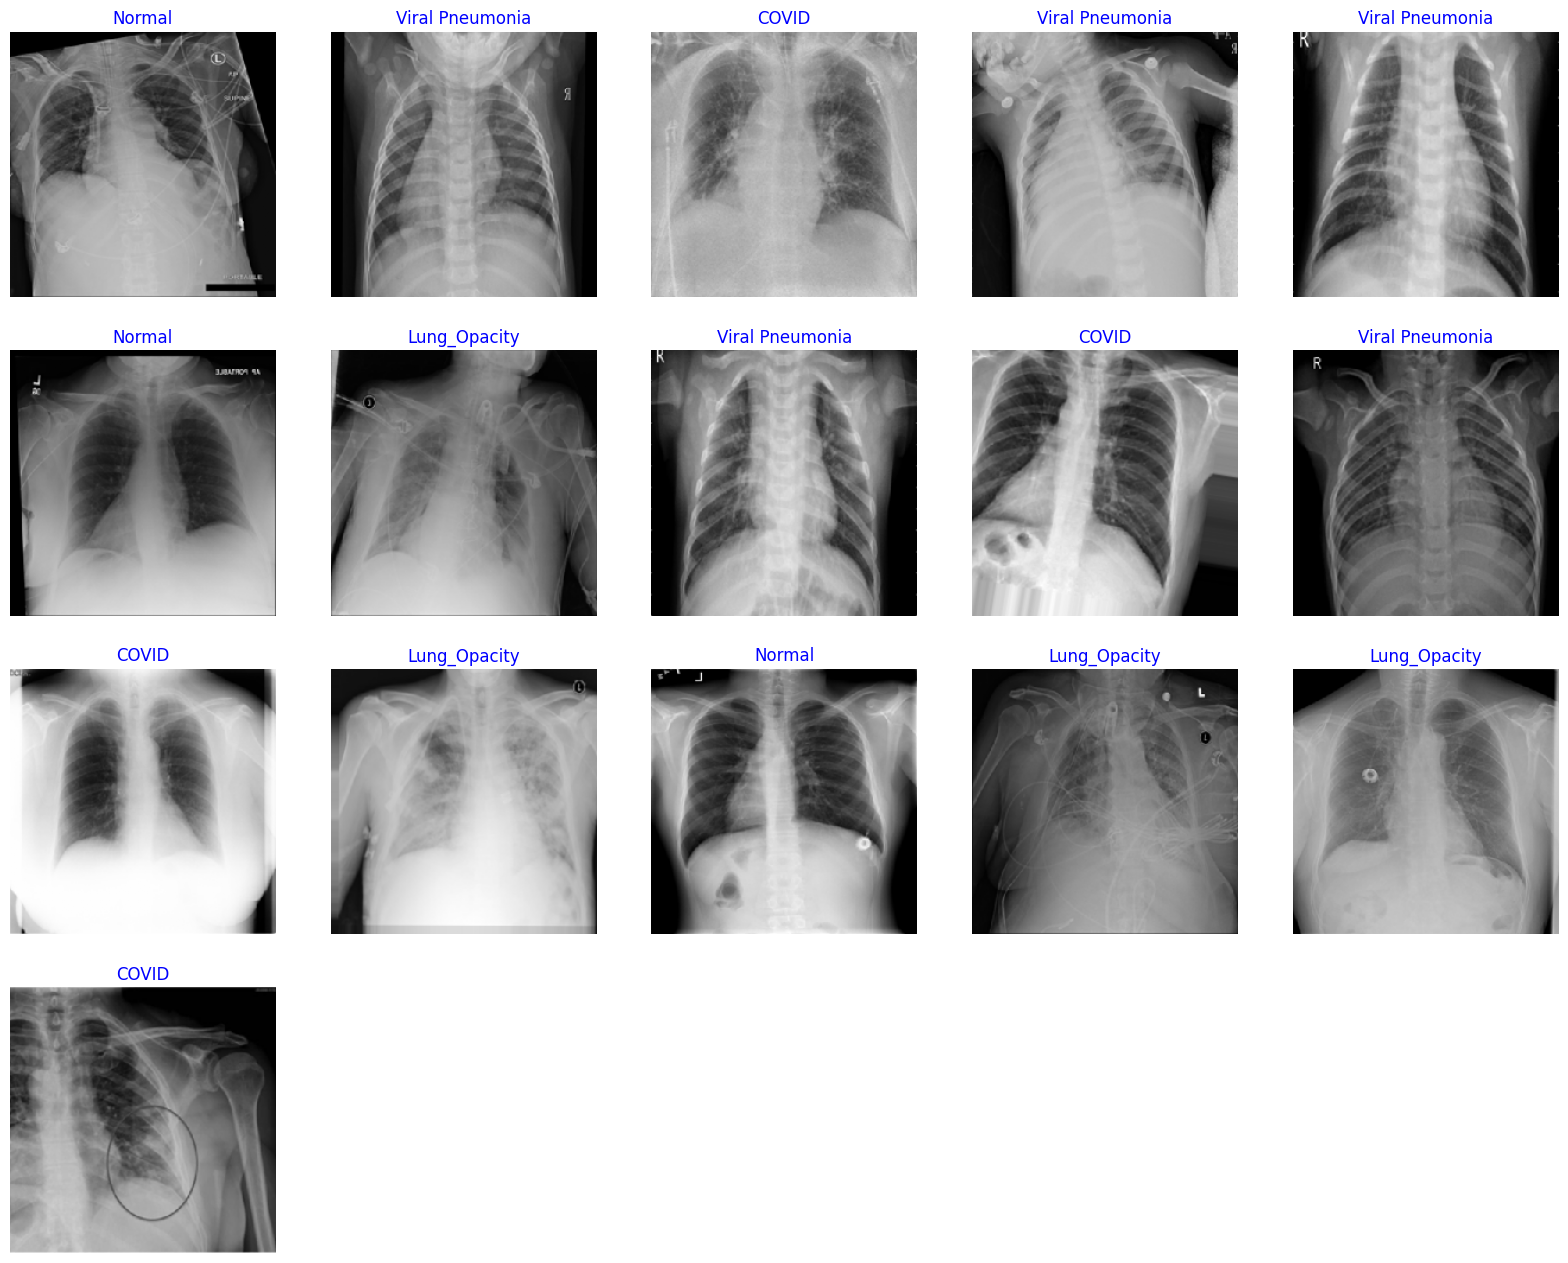

In [46]:
show_images(train_gen)

# **Building the model and Evaluating the result**

In [47]:
class MyCallback(keras.callbacks.Callback):
  '''
  This class allows the user to hault the number if epochs as per user needs
  '''
  def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
      super(MyCallback, self).__init__()
      self.model = model
      self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
      self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
      self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
      self.factor = factor # factor by which to reduce the learning rate
      self.batches = batches # number of training batch to run per epoch
      self.epochs = epochs
      self.ask_epoch = ask_epoch
      self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

      # callback variables
      self.count = 0 # how many times lr has been reduced without improvement
      self.stop_count = 0
      self.best_epoch = 1   # epoch with the lowest loss
      self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
      self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
      self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
      self.best_weights = self.model.get_weights() # set best weights to model's initial weights
      self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

  # Define a function that will run when train begins
  def on_train_begin(self, logs= None):
      msg = 'Do you want model asks you to halt the training [y/n] ?'
      print(msg)
      ans = input('')
      if ans in ['Y', 'y']:
          self.ask_permission = 1
      elif ans in ['N', 'n']:
          self.ask_permission = 0

      msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
      print(msg)
      self.start_time = time.time()


  def on_train_end(self, logs= None):
      stop_time = time.time()
      tr_duration = stop_time - self.start_time
      hours = tr_duration // 3600
      minutes = (tr_duration - (hours * 3600)) // 60
      seconds = tr_duration - ((hours * 3600) + (minutes * 60))

      msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
      print(msg)

      # set the weights of the model to the best weights
      self.model.set_weights(self.best_weights)


  def on_train_batch_end(self, batch, logs= None):
      # get batch accuracy and loss
      acc = logs.get('accuracy') * 100
      loss = logs.get('loss')

      # prints over on the same line to show running batch count
      msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
      print(msg, '\r', end= '')


  def on_epoch_begin(self, epoch, logs= None):
      self.ep_start = time.time()


  # Define method runs on the end of each epoch
  def on_epoch_end(self, epoch, logs= None):
      ep_end = time.time()
      duration = ep_end - self.ep_start

      lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
      current_lr = lr
      acc = logs.get('accuracy')  # get training accuracy
      v_acc = logs.get('val_accuracy')  # get validation accuracy
      loss = logs.get('loss')  # get training loss for this epoch
      v_loss = logs.get('val_loss')  # get the validation loss for this epoch

      if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
          monitor = 'accuracy'
          if epoch == 0:
              pimprov = 0.0
          else:
              pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

          if acc > self.highest_tracc: # training accuracy improved in the epoch
              self.highest_tracc = acc # set new highest training accuracy
              self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
              self.count = 0 # set count to 0 since training accuracy improved
              self.stop_count = 0 # set stop counter to 0
              if v_loss < self.lowest_vloss:
                  self.lowest_vloss = v_loss
              self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

          else:
              # training accuracy did not improve check if this has happened for patience number of epochs
              # if so adjust learning rate
              if self.count >= self.patience - 1: # lr should be adjusted
                  lr = lr * self.factor # adjust the learning by factor
                  tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                  self.count = 0 # reset the count to 0
                  self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                  self.count = 0 # reset counter
                  if v_loss < self.lowest_vloss:
                      self.lowest_vloss = v_loss
              else:
                  self.count = self.count + 1 # increment patience counter

      else: # training accuracy is above threshold so adjust learning rate based on validation loss
          monitor = 'val_loss'
          if epoch == 0:
              pimprov = 0.0

          else:
              pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

          if v_loss < self.lowest_vloss: # check if the validation loss improved
              self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
              self.best_weights = self.model.get_weights() # validation loss improved so save the weights
              self.count = 0 # reset count since validation loss improved
              self.stop_count = 0
              self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

          else: # validation loss did not improve
              if self.count >= self.patience - 1: # need to adjust lr
                  lr = lr * self.factor # adjust the learning rate
                  self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                  self.count = 0 # reset counter
                  tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

              else:
                  self.count = self.count + 1 # increment the patience counter

              if acc > self.highest_tracc:
                  self.highest_tracc = acc

      msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
      print(msg)

      if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
          msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
          print(msg)
          self.model.stop_training = True # stop training

      else:
          if self.ask_epoch != None and self.ask_permission != 0:
              if epoch + 1 >= self.ask_epoch:
                  msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                  print(msg)

                  ans = input('')
                  if ans == 'H' or ans == 'h':
                      msg = f'training has been halted at epoch {epoch + 1} due to user input'
                      print(msg)
                      self.model.stop_training = True # stop training

                  else:
                      try:
                          ans = int(ans)
                          self.ask_epoch += ans
                          msg = f' training will continue until epoch {str(self.ask_epoch)}'
                          print(msg)
                          msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                          print(msg)

                      except Exception:
                          print('Invalid')

In [48]:
#import tensorflow_hub as hub

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
#keras_layer = hub.KerasLayer('https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2')
base_model = tf.keras.applications.resnet50.ResNet50(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [49]:
batch_size = 16   # set batch size for training
epochs = 100   # number of all epochs in training
patience = 3   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [50]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    2.208   78.470   1.88871  72.448   0.00100  0.00100  accuracy     0.00    119.63 
 2 /100    0.570   89.153   0.75768  85.870   0.00100  0.00100  accuracy    13.61    70.02  
 3 /100    0.375   91.552   0.57738  84.263   0.00100  0.00100  val_loss    23.80    69.93  
 4 /100    0.271   93.259   3.39108  65.974   0.00100  0.00100  val_loss   -487.32   69.53  
 5 /100    0.464   91.279   1.28894  76.938   0.00100  0.00100  val_loss   -123.24   69.81  
enter H to halt training or an integer for number of epochs to run then ask again
5
 training will continue until epoch 10
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /100    0.307   93.041   2.54000  52.457   0.00100  0.00050  val_loss   -339.92   72.51  
 7 /100    0.144   96.548   0.71867  80.907   0.00050  0.00050  val_loss    -

In [51]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

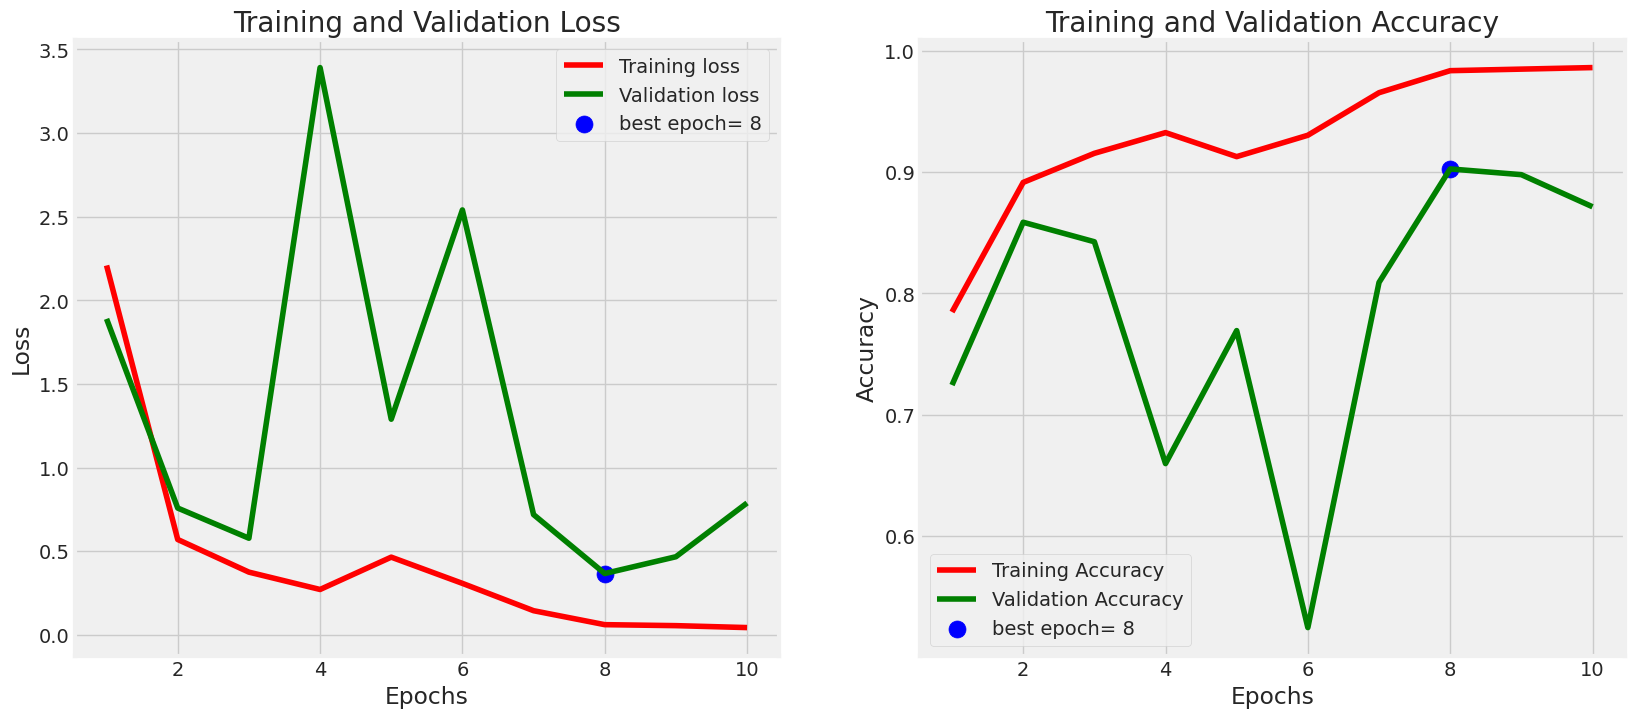

In [52]:
plot_training(history)

In [53]:
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))

In [54]:
y_pred = []
y_true=test_gen.labels
classes=list(test_gen.class_indices.keys())
class_count=len(classes)
errors=0 #store errors
preds=model.predict(test_gen, verbose=1)

tests=len(preds)

#loop to check the number of errors
for i, j in enumerate(preds):
    pred_index=np.argmax(j)
    true_index=test_gen.labels[i]
    if pred_index != true_index: # is predicted label=true label?
        errors=errors + 1
    y_pred.append(pred_index)

ypred=np.array(y_pred)
ytrue=np.array(y_true)

supervised_metrics(y_true, y_pred)

29/29 [==============================] - 13s 328ms/step
Accuracy : 90.26924893717525 %
F1 Score : 0.9025933568065144
Recall : 0.9026924893717525
Precision : 0.9042778751345653


In [55]:
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
  """"Confusion Matrix for true values and predicted values"""
  cm = metrics.confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)
  plt.figure(figsize = figsize)
  plt.tight_layout()
  tick_marks = np.arange(len(classes))
  sns.heatmap(cm, annot=True, cmap="crest")
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes, rotation=45)

  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title('Confusion Matrix')
  plt.show()

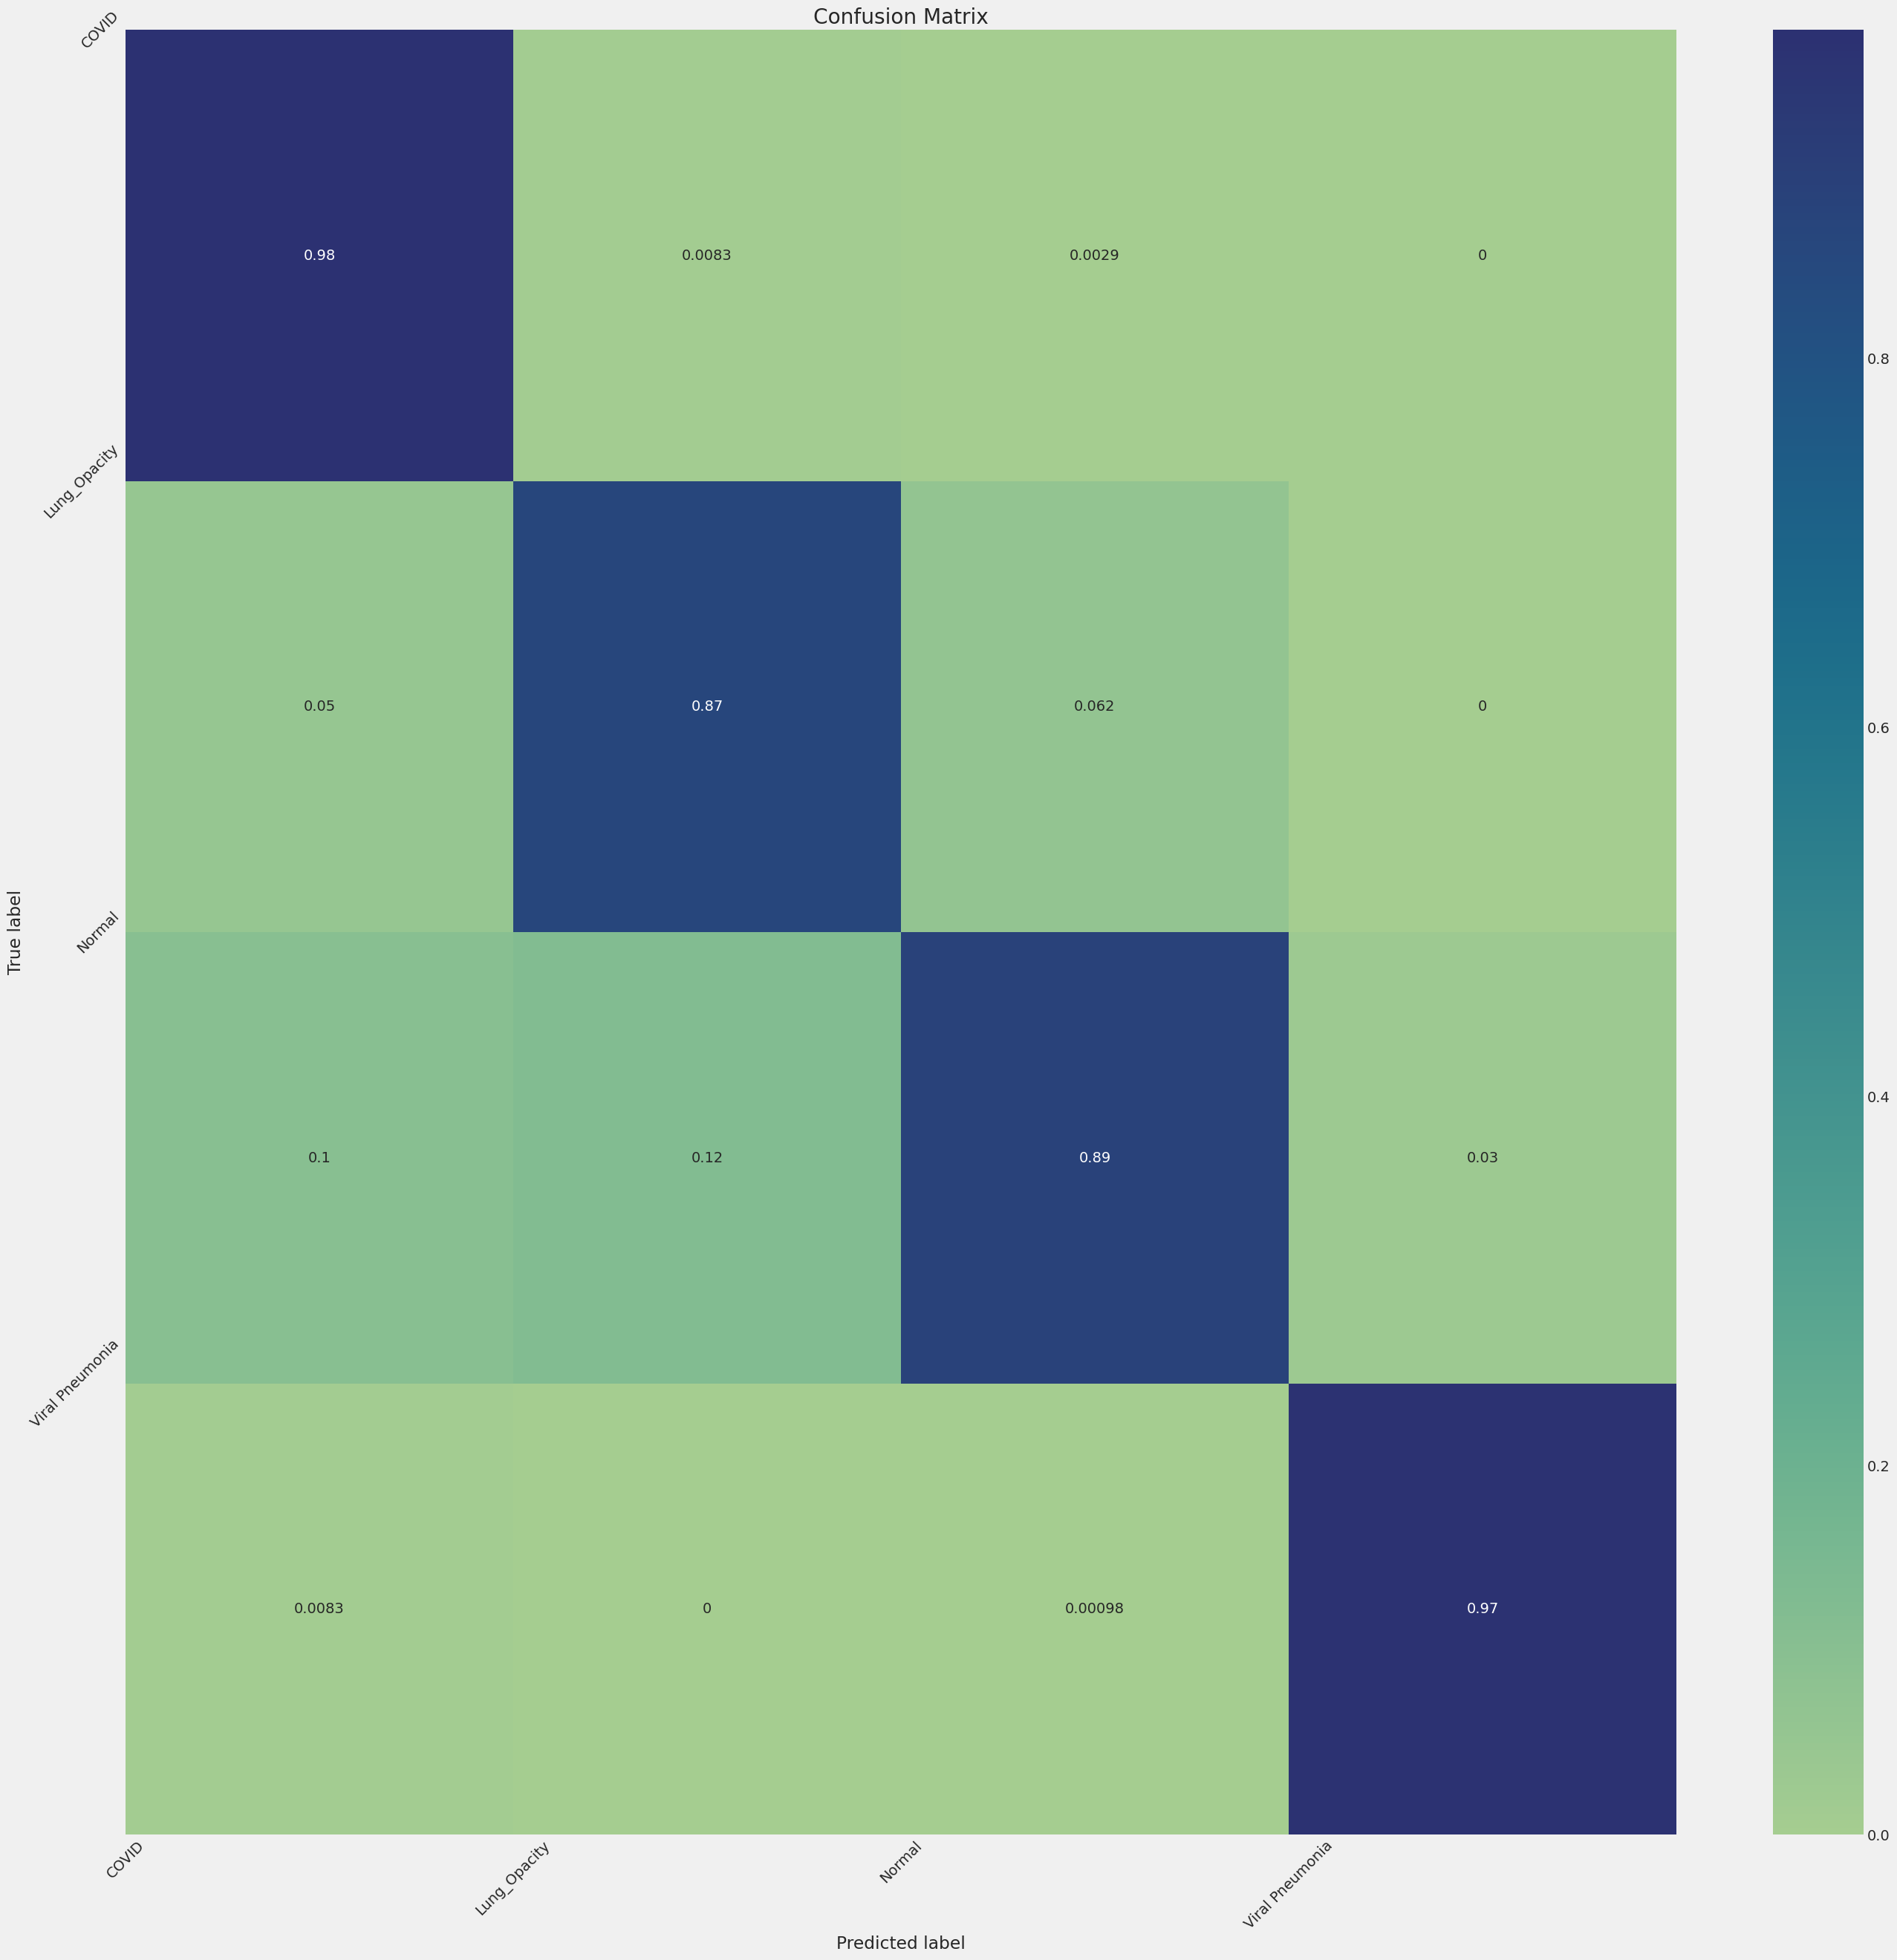

In [56]:
confusion_matrix_plot(y_true, y_pred, figsize=(30,30))

In [57]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

29/29 [==============================] - 9s 307ms/step - loss: 0.3418 - accuracy: 0.9027
Train Loss:  0.052408408373594284
Train Accuracy:  0.9806034564971924
--------------------
Validation Loss:  0.37274929881095886
Validation Accuracy:  0.9030172228813171
--------------------
Test Loss:  0.34181541204452515
Test Accuracy:  0.9026924967765808


In [58]:
model_name = model.input_names[0][:-6]
subject = 'Trim-Augumentation'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as resnet50-Trim-Augumentation-90.27.h5
weights were saved as resnet50-Trim-Augumentation-weights.h5
